# Homologous cell-types definition
## To match macrophage cell-types between adult mice and zebrafish

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
from matplotlib import font_manager
font_manager.fontManager.addfont('/cluster/groups/Wangxiaonan/share/yingjun/arial.ttf')
plt.rcParams['font.sans-serif'] = 'Arial'

/cluster/home/yingjun/miniconda3/envs/sc182/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cluster/home/yingjun/miniconda3/envs/sc182/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cluster/home/yingjun/miniconda3/envs/sc182/lib/python

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.24.4 scipy==1.9.3 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.8


# Scoring using top 100 DEG

## preprocess

In [59]:
adata = sc.read('./Final_write/mouse_mac_final.h5ad')

In [11]:
adata = anndata.AnnData(X=adata.raw.X.A,var=adata.raw.var,obs=adata.obs,obsm=adata.obsm)
# adata.write('./write/Macro_outerRaw.h5ad')

In [12]:
# Scale
sc.pp.scale(adata,max_value=10)

In [13]:
np.max(adata.X)

10.0

## Start scoring

In [4]:
gdict = pd.read_csv('./Final_Files/TransedMouse100Marker_Outer',index_col=0)

In [5]:
gdict = gdict.to_dict()

In [ ]:
for k, v in gdict.items():
    sc.tl.score_genes(adata, gene_list=v.values(), score_name='Score_'+k, use_raw=False)

In [15]:
sname = [x for x in adata.obs_keys() if 'Score_' in x]

In [16]:
adata.obs['t2'] = np.std(adata.obs[sname], axis=1)

In [17]:
s2 = adata.obs[sname].max(axis=1)

In [18]:
adata.obs['s2'] = s2

In [ ]:
sc.pl.umap(adata,color='s2',cmap='bwr',title='Score',save='_s2.pdf')

In [20]:
adata.obs['Score']=adata.obs.s2

In [ ]:
ax = pd.DataFrame(adata.obs['Score']).plot.kde(xlim=(-0.5,1.5))
ax.axvline(0.05, linestyle='--', color='orange')
plt.savefig('s2_density.pdf',bbox_inches='tight')

In [23]:
Tn = adata.obs[sname].idxmax(axis=1)

In [24]:
adata.obs['Tn'] = [re.sub('Score_', '',x) for x in Tn]

In [25]:
tk = [adata.obs.Tn[x] if adata.obs.s2[x]>0.05 else 'NA' for x in adata.obs_names]

In [26]:
adata.obs['Tn2'] = tk

In [27]:
adata.obs['Tn'].value_counts()

mafbb                3029
apoeb                2376
cd59                 2251
proliferating        2182
epdl                 1631
il1b                 1553
Fibroblast duplex    1371
Ery duplex           1263
Endothelia duplex    1029
CM duplex             994
Name: Tn, dtype: int64

In [28]:
adata.obs['Tn2'].value_counts()

mafbb                2893
apoeb                2329
proliferating        2122
cd59                 2108
epdl                 1533
il1b                 1456
Fibroblast duplex    1244
NA                   1151
Ery duplex           1147
CM duplex             854
Endothelia duplex     842
Name: Tn2, dtype: int64

In [29]:
adata2 = adata[adata.obs.Tn2!='NA']

In [84]:
cat = ['Ma-TR-Cd163', 'Ma-TR-Cd83+', 'Ma-TR-Cd83-', 'Ma-MD-Mpeg1',
       'Ma-MD-Prdx1', 'Ma-MD-Cxcl3', 'Ma-MD-Isg15', 'Ma-MD-Ccl2', 'Ma-Fn1', 'Ma-Fibro',
       'Ma-Endo', 'Ma-Cycling', 'Ma-lowGC']
adata2.obs['Tn2'] = adata2.obs.Tn2.astype('category').cat.reorder_categories(cat)

In [ ]:
sc.pl.umap(adata2,color=['Tn2'],wspace=0.5,title='Adult_Mice')

In [99]:
col = ['#d6bcc0', '#bb7784', '#8e063b','#00008B', '#4a6fe3', '#8595e1','#FF8C00','#634040', '#ADFF2F', '#32CD32', '#006400', '#C0C0C0', '#bec1d4']
adata2.uns['Tn2_colors'] = col

/cluster/home/yingjun/miniconda3/envs/sc182/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


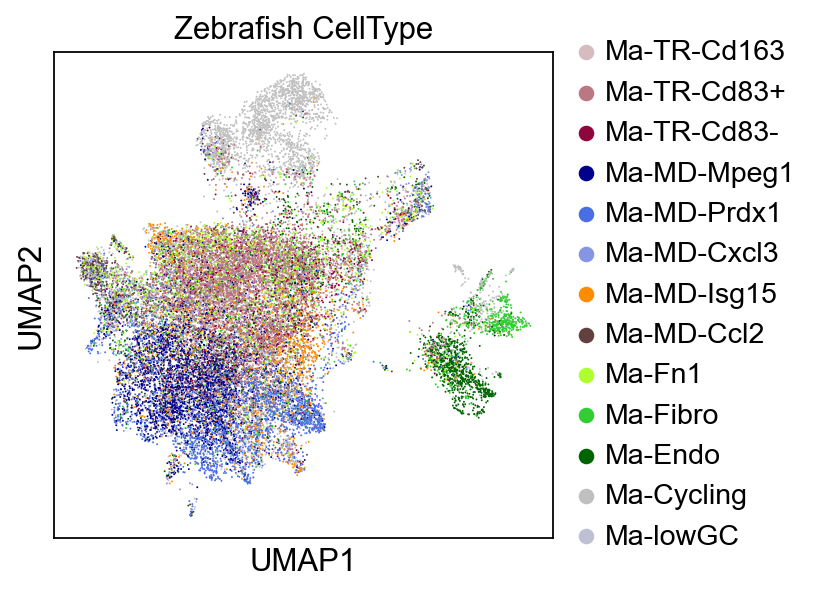

In [106]:
sc.pl.umap(adata2,color=['Tn2'],size=3,title='Zebrafish CellType')          

In [ ]:
sc.tl.rank_genes_groups(adata2, 'Tn2', n_genes=adata2.shape[1], key_added='DE_Tn2')

/cluster/home/yingjun/miniconda3/envs/sc182/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
meta NOT subset; don't know how to subset; dropped


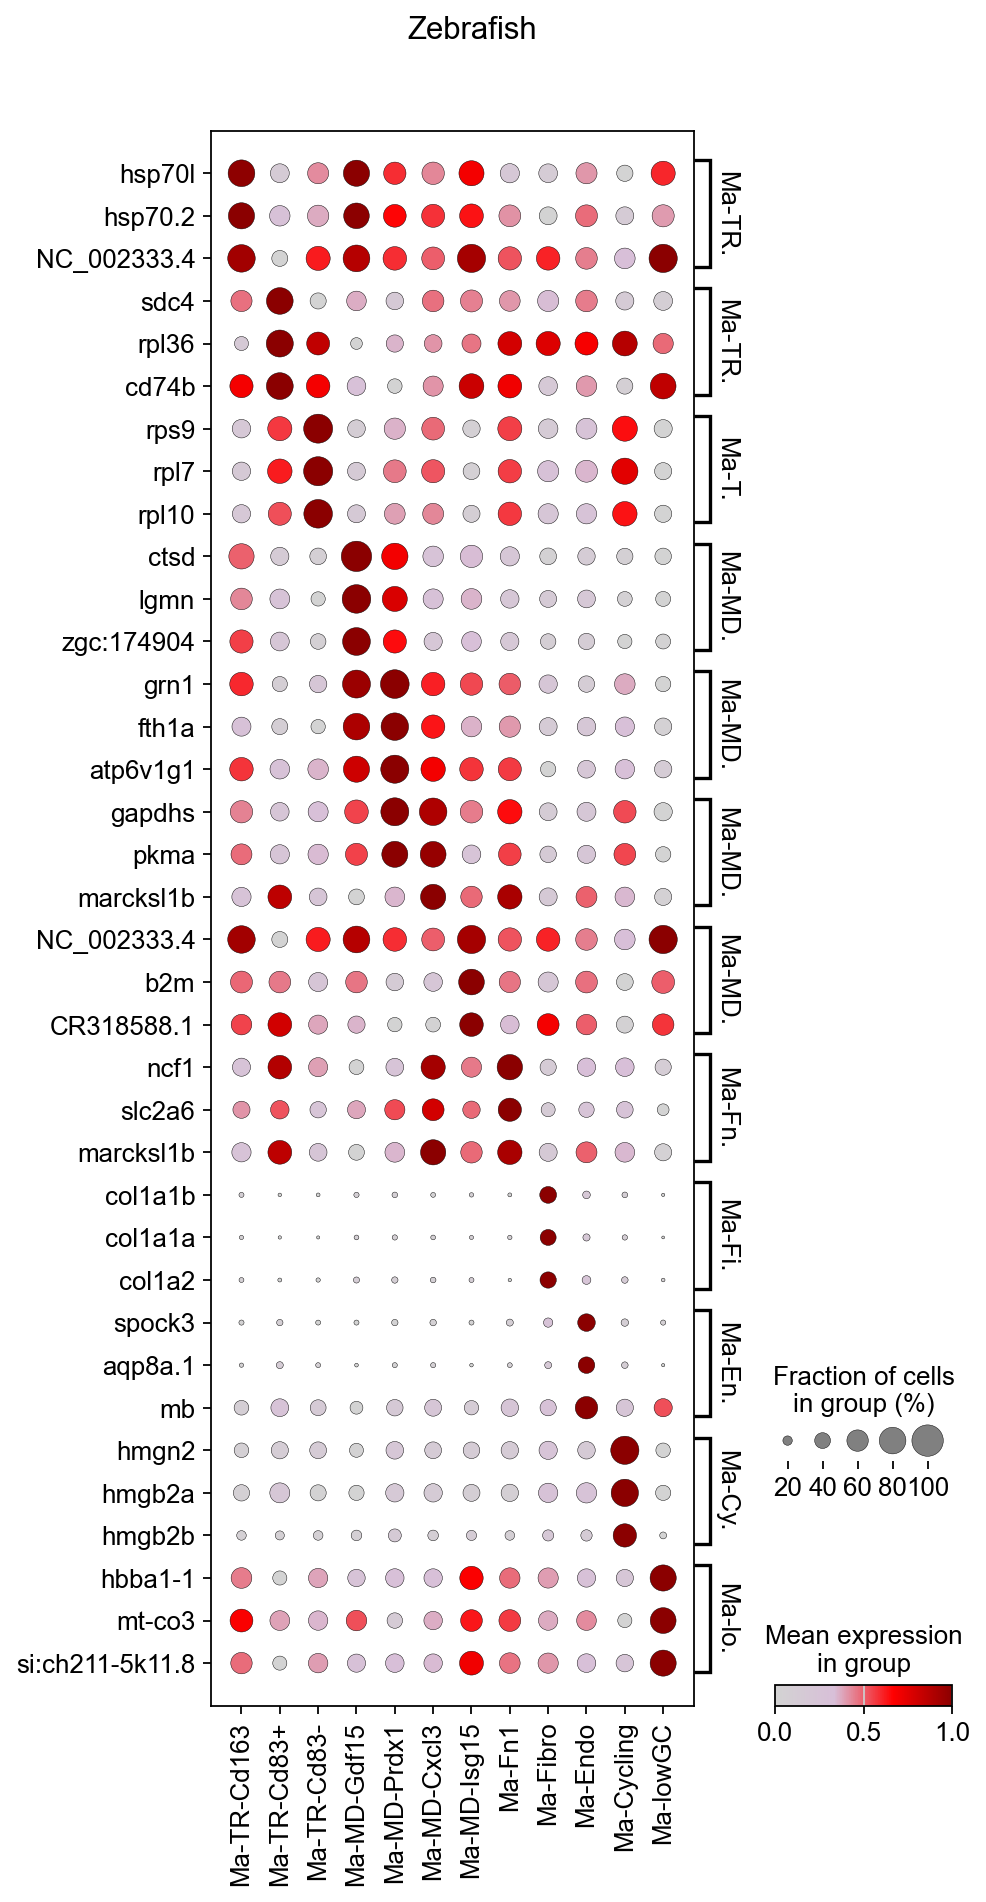

In [176]:
sc.pl.rank_genes_groups_dotplot(adata2,key='DE_Tn2',groupby='Tn2', cmap=cmap, swap_axes=True, standard_scale='var',dendrogram=False,n_genes=3,title='Zebrafish',
                                save="fish_markers.pdf"
                               )

In [ ]:
adata2.write('./write/Macro_outerRaw_CT3scored_filtered.h5ad')

In [ ]:
adata = sc.read('./write/Macro_outerRaw_scored_filtered.h5ad')